In [1]:
import os
import pandas as pd
import numpy as np
import json
import folium

%matplotlib inline
import matplotlib.pyplot as plt

# Task 1 : Choropleth map for Europe

We found a dataset for unemployment rates in Europe countries on the reported website : http://appsso.eurostat.ec.europa.eu/nui/submitViewTableAction.do. We can select the informations that we need (for example restricting the values for the year 2016) and add additional informations (for example adding countries which are not in the european union. We will only keep the total unemployment rates of 2016 (most recent date) regardless of other parameters.

## Data importation and cleaning

We are reading the data set and cleaning it.

In [2]:
europe_unemployment_file = 'eurostat_unemployment_rates_2016.csv'
europe_unemployment = pd.read_csv(europe_unemployment_file)
europe_unemployment.head()

,TIME,GEO,SEX,AGE,CITIZEN,UNIT,Value,Flag and Footnotes
0,2016,European Union (28 countries),Total,From 15 to 74 years,Total,Percentage,8.6,NaN
1,2016,European Union (27 countries),Total,From 15 to 74 years,Total,Percentage,8.5,NaN
2,2016,European Union (15 countries),Total,From 15 to 74 years,Total,Percentage,9.1,NaN
3,2016,Euro area (19 countries),Total,From 15 to 74 years,Total,Percentage,10.0,NaN
4,2016,Euro area (18 countries),Total,From 15 to 74 years,Total,Percentage,10.1,NaN


We only want to keep the total unemployment rates so we are dropping the useless columns.

In [3]:
europe_unemployment = europe_unemployment[['GEO','Value']]
europe_unemployment.columns = ['Country', 'Rate']
europe_unemployment.head()

,Country,Rate
0,European Union (28 countries),8.6
1,European Union (27 countries),8.5
2,European Union (15 countries),9.1
3,Euro area (19 countries),10.0
4,Euro area (18 countries),10.1


Some names are not matching the ones in the topojson/europe.topojson.json file. We need them to match to plot the choropleth map. We have to replace those values :

In [4]:
europe_unemployment.loc[europe_unemployment['Country'] == 'Germany (until 1990 former territory of the FRG)', 'Country'] = 'Germany'
europe_unemployment.loc[europe_unemployment['Country'] == 'Former Yugoslav Republic of Macedonia, the', 'Country'] = 'The former Yugoslav Republic of Macedonia'
europe_unemployment.head()

,Country,Rate
0,European Union (28 countries),8.6
1,European Union (27 countries),8.5
2,European Union (15 countries),9.1
3,Euro area (19 countries),10.0
4,Euro area (18 countries),10.1


And finally we can drop the rows that are not needed, containing informations about non european countries or average values.

In [5]:
europe_unemployment = europe_unemployment[europe_unemployment['Country'] != 'European Union (28 countries)']
europe_unemployment = europe_unemployment[europe_unemployment['Country'] != 'European Union (27 countries)']
europe_unemployment = europe_unemployment[europe_unemployment['Country'] != 'European Union (15 countries)']
europe_unemployment = europe_unemployment[europe_unemployment['Country'] != 'Euro area (19 countries)']
europe_unemployment = europe_unemployment[europe_unemployment['Country'] != 'Euro area (18 countries)']
europe_unemployment = europe_unemployment[europe_unemployment['Country'] != 'Euro area (17 countries)']


europe_unemployment.reset_index(drop=True, inplace=True)

## Plotting the european map

For the plot of the map, we used a dark background to make colors more visible. We used 6 intervals of colors, making countries with unemployment rates differing by 4% or less the same color.

For some countries in the topojson/europe.topojson.json we don't have the corresponding value in the data frame. So we defined our own style_function and threshold_scale to make countries with unknown values grey.

In [6]:
europe_topo_path = 'topojson/europe.topojson.json'
europe_topo_json = json.load(open(europe_topo_path))

In [7]:
def style_function(feature):
    country = europe_unemployment[europe_unemployment['Country']==feature['properties']['NAME']]['Country'].tolist() 
    if len(country) == 0:
        return {
            'fillOpacity': 0.5,
            'weight': 0,
            'fillColor': '#black'

        }
    else:
        return {
            'fillOpacity': 0,
            'weight': 0,
            'fillColor': '#white'
        
        }

In [8]:
threshold_scale = np.linspace(europe_unemployment['Rate'].min(),
                              europe_unemployment['Rate'].max(), 6, dtype=float).tolist()

m_europe = folium.Map([50,0], tiles='Stamen Terrain', zoom_start=4)
m_europe.choropleth(geo_data=europe_topo_json, topojson='objects.europe', data=europe_unemployment,
             columns=['Country', 'Rate'],
             key_on='feature.properties.NAME',
             fill_color='YlOrBr', fill_opacity=0.7, line_opacity=0.5,
             legend_name='Unemployment rates in EUROPE (%)',
             threshold_scale=threshold_scale)

import branca
colorscale = branca.colormap.linear.YlOrRd.scale(0, 20)

folium.TopoJson(
    open(europe_topo_path),
    'objects.europe',
    style_function=style_function
).add_to(m_europe)

m_europe

The unemployment rate in Switzerland is one of the lowest in Europe. We can indeed plot the 15 countries with the lowest unemployment rates and see that it is the 7th lowest in Europe, after Iceland.

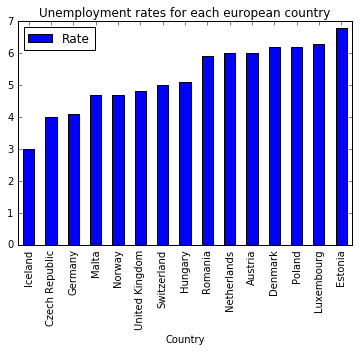

In [9]:
europe_unemployment.nsmallest(n=15,columns=['Rate']).plot(kind='bar',x='Country',y='Rate',title='Unemployment rates for each european country');

# Task 2 : Choropleth map for Switzerland

We found a dataset containing the unemployment rates of the year 2016 for each canton in Switzerland. We cleaned the csv file a little bit (mainly removing useless characters) and saved the cleaned version for a future reuse.

In [10]:
switz_unemployment = pd.read_csv('switz_unemployment.csv', encoding='utf-16', thousands='\'')
switz_unemployment.head()

,Année,Canton,durchschnittliche Anzahl Arbeitslose,Taux de chômage (1 cav),durchschnittliche Anzahl Jugendarbeitslose,Taux de chômage des jeunes (1 pdv),durchschnittliche Anzahl Arbeitslose (älter als 50 Jahre),Taux de chômage (1 cav).1
0,2016,Zurich,30084,3.7,3711,4.1,7191,3.1
1,2016,Berne,15283,2.7,2111,2.9,4225,2.4
2,2016,Lucerne,4602,2.1,758,2.4,1196,1.8
3,2016,Uri,202,1.0,27,0.9,56,1.0
4,2016,Schwyz,1537,1.8,178,1.5,541,2.0


We are interested only in the canton and the unemployment rate :

In [11]:
switz_unemployment = switz_unemployment[['Canton', 'Taux de chômage (1 cav)']]
switz_unemployment.columns = ['Canton', 'Rate']
switz_unemployment.head()

,Canton,Rate
0,Zurich,3.7
1,Berne,2.7
2,Lucerne,2.1
3,Uri,1.0
4,Schwyz,1.8


## Plotting the map

We will need the abbreviations of each canton matching the ones used in the json file to plot the map.

In [12]:
abbreviations = {'Zurich' : 'ZH',
                 'Berne' :  'BE',
                 'Lucerne': 'LU',
                 'Uri' : 'UR',
                 'Schwyz' : 'SZ',
                 'Obwald' : 'OW',
                 'Nidwald' : 'NW',
                 'Glaris' : 'GL',
                 'Zoug' : 'ZG',
                 'Fribourg' : 'FR',
                 'Soleure' : 'SO',
                 'Bâle-Ville' : 'BS',
                 'Bâle-Campagne' : 'BL',
                 'Schaffhouse' : 'SH',
                 'Appenzell Rhodes-Extérieures' : 'AR',
                 'Appenzell Rhodes-Intérieures' : 'AI',
                 'St-Gall' : 'SG',
                 'Grisons' : 'GR',
                 'Argovie' : 'AG',
                 'Thurgovie' : 'TG',
                 'Tessin' : 'TI',
                 'Vaud' : 'VD',
                 'Valais' : 'VS',
                 'Neuchâtel' : 'NE',
                 'Genève' : 'GE',
                 'Jura' : 'JU'}
switz_unemployment = switz_unemployment.assign(Abbr = switz_unemployment['Canton'].map(abbreviations))
switz_unemployment.head()

,Canton,Rate,Abbr
0,Zurich,3.7,ZH
1,Berne,2.7,BE
2,Lucerne,2.1,LU
3,Uri,1.0,UR
4,Schwyz,1.8,SZ


Let's load the topojson file needed to plot the map :

In [13]:
switz_topo_path = 'topojson/ch-cantons.topojson.json'
switz_topo_json = json.load(open(switz_topo_path))

**We can finally plot the map :**

In [14]:
m_switz = folium.Map([46.8, 8.13], tiles='CartoDB positron', zoom_start=7.5)
m_switz.choropleth(geo_data=switz_topo_json, topojson='objects.cantons', data=switz_unemployment,
             columns=['Abbr', 'Rate'],
             key_on='feature.id',
             fill_color='YlOrBr', fill_opacity=0.7, line_opacity=0.2,
             legend_name='Unemployment rates in Switz cantons (%)')
m_switz

## Using a different definition of unemployment rate

The rates used in the precedent part are the ratio of the number of people looking for a job divided by the size of the active population. Let's use now another definition of unemployment rate, only counting the people who have no job in the number of jobseekers. We will then compare the different results.

We downloaded a different data set including the number of unemployed people and jobseekers for each month of the year 2016. We first have to clean it to work with it.

In [15]:
switz_unemployment2 = pd.read_csv('switz_unemployment_extended_raw.csv', encoding='utf-8', thousands='\'')
switz_unemployment2.head()

,Canton,Mois,Janvier 2016,Janvier 2016.1,Janvier 2016.2,Janvier 2016.3,Janvier 2016.4,Février 2016,Février 2016.1,Février 2016.2,...,Novembre 2016,Novembre 2016.1,Novembre 2016.2,Novembre 2016.3,Novembre 2016.4,Décembre 2016,Décembre 2016.1,Décembre 2016.2,Décembre 2016.3,Décembre 2016.4
0,Canton,Mois,Janvier 2016,Janvier 2016,Janvier 2016,Janvier 2016,Janvier 2016,Février 2016,Février 2016,Février 2016,...,Novembre 2016,Novembre 2016,Novembre 2016,Novembre 2016,Novembre 2016,Décembre 2016,Décembre 2016,Décembre 2016,Décembre 2016,Décembre 2016
1,Mesures,Chômeurs inscrits,Chômeurs jeunes,Chômeurs de longue durée,Demandeurs d'emploi,Demandeurs d'emploi non chômeurs,Chômeurs inscrits,Chômeurs jeunes,Chômeurs de longue durée,Demandeurs d'emploi,...,Chômeurs jeunes,Chômeurs de longue durée,Demandeurs d'emploi,Demandeurs d'emploi non chômeurs,Chômeurs inscrits,Chômeurs jeunes,Chômeurs de longue durée,Demandeurs d'emploi,Demandeurs d'emploi non chômeurs,NaN
2,Zurich,31'331,4'076,4'770,37'642,6'311,31'502,3'968,4'844,37'956,...,3'753,5'113,37'720,7'069,31'570,3'709,5'245,38'591,7'021,NaN
3,Berne,16'502,2'425,2'291,21'053,4'551,16'264,2'278,2'377,20'982,...,2'213,2'616,20'961,5'208,16'636,2'315,2'765,21'637,5'001,NaN
4,Lucerne,5'164,840,548,7'897,2'733,5'040,799,572,7'903,...,780,539,7'549,3'120,4'883,821,582,7'871,2'988,NaN


As the values are extremely close month after month, we decided to keep only one of them, for example January (taking the average would give almost the same values).

In [16]:
switz_unemployment2 = switz_unemployment2[['Canton', 'Janvier 2016', 'Janvier 2016.1', 'Janvier 2016.2', 'Janvier 2016.3', 'Janvier 2016.4']]
switz_unemployment2.head()

,Canton,Janvier 2016,Janvier 2016.1,Janvier 2016.2,Janvier 2016.3,Janvier 2016.4
0,Canton,Janvier 2016,Janvier 2016,Janvier 2016,Janvier 2016,Janvier 2016
1,Mesures,Chômeurs jeunes,Chômeurs de longue durée,Demandeurs d'emploi,Demandeurs d'emploi non chômeurs,Chômeurs inscrits
2,Zurich,4'076,4'770,37'642,6'311,31'502
3,Berne,2'425,2'291,21'053,4'551,16'264
4,Lucerne,840,548,7'897,2'733,5'040


We now rename the columns to make it cleaner and more explicit :

In [17]:
switz_unemployment2.rename(columns={'Janvier 2016' : 'Young unemployed', 'Janvier 2016.1' : 'Long unemployed', 'Janvier 2016.2' : 'Jobseekers', 'Janvier 2016.3' : 'Jobseekers not unemployed', 'Janvier 2016.4' : 'Registered unemployed'}, inplace=True)
switz_unemployment2 = switz_unemployment2.iloc[2:]
switz_unemployment2.reset_index(drop=True, inplace=True)
switz_unemployment2.head()

,Canton,Young unemployed,Long unemployed,Jobseekers,Jobseekers not unemployed,Registered unemployed
0,Zurich,4'076,4'770,37'642,6'311,31'502
1,Berne,2'425,2'291,21'053,4'551,16'264
2,Lucerne,840,548,7'897,2'733,5'040
3,Uri,36,18,440,184,262
4,Schwyz,212,143,2'425,714,1'723


In order to use this data frame later we saved it in a .csv file :

In [18]:
switz_unemployment2 = switz_unemployment2.to_csv('switz_unemployment_extended.csv', encoding='utf-8', sep=',', index=False)
switz_unemployment2 = pd.read_csv('switz_unemployment_extended.csv', encoding='utf-8', thousands='\'')
switz_unemployment2.head()

,Canton,Young unemployed,Long unemployed,Jobseekers,Jobseekers not unemployed,Registered unemployed
0,Zurich,4076,4770,37642,6311,31502
1,Berne,2425,2291,21053,4551,16264
2,Lucerne,840,548,7897,2733,5040
3,Uri,36,18,440,184,262
4,Schwyz,212,143,2425,714,1723


These are just raw numbers and we don't know what the active population is in each canton. We decided to use the first data set for Switzerland, including the rates of unemployed people in each canton to calculate the number of active people.

The rates are indeed equal to (Number of jobseekers)/(Active population). We know the rates and the number of jobseekers thanks to the second data set, so we can guess the active population.

Let's first compare if the cantons are ordered the same way in both data frames (switz_unemployment2 has one more row with Total numbers).

In [19]:
switz_unemployment['Canton'].equals(switz_unemployment2['Canton'].iloc[:(len(switz_unemployment2) - 1)])

True

In [20]:
switz_active = 100*switz_unemployment2['Jobseekers'].iloc[:(len(switz_unemployment2) - 1)]/switz_unemployment['Rate']
switz_active.head()

0    1.017351e+06
1    7.797407e+05
2    3.760476e+05
3    4.400000e+04
4    1.347222e+05
dtype: float64

In [21]:
switz_active = pd.concat([switz_unemployment['Canton'], switz_active], axis=1, keys=['Canton', 'Active'])
switz_active.head()

,Canton,Active
0,Zurich,1.017351e+06
1,Berne,7.797407e+05
2,Lucerne,3.760476e+05
3,Uri,4.400000e+04
4,Schwyz,1.347222e+05


In [22]:
switz_unemployment2['Active'] = switz_active['Active']
switz_unemployment2.head()

,Canton,Young unemployed,Long unemployed,Jobseekers,Jobseekers not unemployed,Registered unemployed,Active
0,Zurich,4076,4770,37642,6311,31502,1.017351e+06
1,Berne,2425,2291,21053,4551,16264,7.797407e+05
2,Lucerne,840,548,7897,2733,5040,3.760476e+05
3,Uri,36,18,440,184,262,4.400000e+04
4,Schwyz,212,143,2425,714,1723,1.347222e+05


We can now calculate the unemployment rate counting only unemployed jobseekers :

In [23]:
switz_unemployment2['Rate unemployed'] = 100*(switz_unemployment2['Jobseekers'] - switz_unemployment2['Jobseekers not unemployed'])/switz_unemployment2['Active']
switz_unemployment2['Rate'] = switz_unemployment['Rate']
switz_unemployment2['Abbr'] = switz_unemployment['Abbr']
switz_unemployment2.head()

,Canton,Young unemployed,Long unemployed,Jobseekers,Jobseekers not unemployed,Registered unemployed,Active,Rate unemployed,Rate,Abbr
0,Zurich,4076,4770,37642,6311,31502,1.017351e+06,3.079664,3.7,ZH
1,Berne,2425,2291,21053,4551,16264,7.797407e+05,2.116344,2.7,BE
2,Lucerne,840,548,7897,2733,5040,3.760476e+05,1.373230,2.1,LU
3,Uri,36,18,440,184,262,4.400000e+04,0.581818,1.0,UR
4,Schwyz,212,143,2425,714,1723,1.347222e+05,1.270021,1.8,SZ


## Plottings and interpretations

Let's plot the results and interpret them now that the data frames are ready to be used.

**The first map including employed jobseekers was :**

In [24]:
m_switz

**Now, with employed jobseekers excluded :**

In [25]:
m_switz2 = folium.Map([46.8, 8.13], tiles='CartoDB positron', zoom_start=7.5)
m_switz2.choropleth(geo_data=switz_topo_json, topojson='objects.cantons', data=switz_unemployment2,
             columns=['Abbr', 'Rate unemployed'],
             key_on='feature.id',
             fill_color='YlOrBr', fill_opacity=0.7, line_opacity=0.2,
             legend_name='Unemployment rates excluding employed jobseekers in Switz cantons (%)')
m_switz2

This plot shows that the unemployment rates are reduced in the same extend in each canton because the colors in both maps are almost always the same. This is pretty intuitive and we could expect this because the number of unemployed job seekers is likely to be proportional to the number of jobseekers. We can indeed check the correlation between these two variables :

Correlation between the number of jobseekers and the number of unemployed jobseekers : 0.996689455137


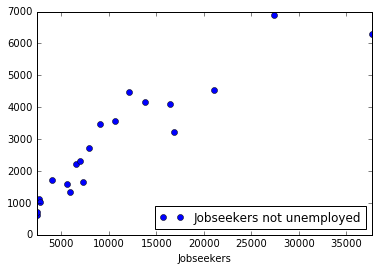

In [26]:
print('Correlation between the number of jobseekers and the number of unemployed jobseekers : ' + str(switz_unemployment2['Jobseekers'].corr(switz_unemployment2['Jobseekers not unemployed'])))
switz_unemployment2.iloc[:(len(switz_unemployment2) - 1)][::-1].plot(x='Jobseekers', y='Jobseekers not unemployed', style='o');

It explains why the maps are so similar. However, if we really want to compare the values of the rates in both cases, we have to use a different scale for colors. To do so, we can simply add the largest value from the first rates in the second rates, as a fake value which only change the scale for filling colors :

In [27]:
m_switz

In [28]:
switz_unemployment2.loc[len(switz_unemployment2) - 1, 'Rate unemployed'] = switz_unemployment['Rate'].max()
m_switz2 = folium.Map([46.8, 8.13], tiles='CartoDB positron', zoom_start=7.5)
m_switz2.choropleth(geo_data=switz_topo_json, topojson='objects.cantons', data=switz_unemployment2,
             columns=['Abbr', 'Rate unemployed'],
             key_on='feature.id',
             fill_color='YlOrBr', fill_opacity=0.7, line_opacity=0.2,
             legend_name='Unemployment rates excluding employed jobseekers in Switz cantons (%)')
switz_unemployment2.loc[len(switz_unemployment2) - 1, 'Rate unemployed'] = np.nan
m_switz2

Now it is clear that the rates are lower in the second case with this rescaling. It shows that the way these unemployment rates are calculated can completly change their values and how they should be interpreted.

# Task 3 : Unemployment rates in Switzerland, making a distinction between Swiss and foreign workers.

We use an excel dataset that includes the unemployment rates in Switzerland from January to September 2017, that we loaded from the amstat website. It contains unemployment rate per canton and per month for both swiss and foreign people. Here what it looks like:

In [29]:
# Load the file 
df = pd.read_excel('switz_unemployment_foreign.xlsx')
df.head()

,Canton,Nationalité,Mois,Janvier 2017,Février 2017,Mars 2017,Avril 2017,Mai 2017,Juin 2017,Juillet 2017,Août 2017,Septembre 2017,Octobre 2017,Total
0,NaN,NaN,Mesures,Taux de chômage,Taux de chômage,Taux de chômage,Taux de chômage,Taux de chômage,Taux de chômage,Taux de chômage,Taux de chômage,Taux de chômage,Taux de chômage,Taux de chômage
1,Zurich,Etrangers,NaN,6.6,6.5,6.3,6,5.7,5.6,5.5,5.3,5.3,0,5.3
2,Zurich,Suisses,NaN,2.9,2.8,2.8,2.7,2.6,2.6,2.6,2.6,2.5,0,2.4
3,Berne,Etrangers,NaN,7.5,7.4,7.1,6.8,6.2,5.7,5.5,5.5,5.5,0,5.7
4,Berne,Suisses,NaN,2.2,2.1,2.1,2,1.9,1.8,1.8,1.9,1.8,0,1.8


We will then delete the useless rows and columns, that is the first row (the one with index 0) and the columns 'Mois' and 'Octobre 2017' which does not contain any information. We now have a clean dataframe to work on:

In [30]:
# Clean the data
df = df.drop(df.index[0])
df = df.drop(['Mois', 'Octobre 2017'], axis=1)
df = df.set_index('Canton')
# recompute the total column without October
df['Total'] = round(10*df['Total'].astype(np.float)/9, 2)
df.head(10)

,Nationalité,Janvier 2017,Février 2017,Mars 2017,Avril 2017,Mai 2017,Juin 2017,Juillet 2017,Août 2017,Septembre 2017,Total
Canton,,,,,,,,,,,
Zurich,Etrangers,6.6,6.5,6.3,6,5.7,5.6,5.5,5.3,5.3,5.89
Zurich,Suisses,2.9,2.8,2.8,2.7,2.6,2.6,2.6,2.6,2.5,2.67
Berne,Etrangers,7.5,7.4,7.1,6.8,6.2,5.7,5.5,5.5,5.5,6.33
Berne,Suisses,2.2,2.1,2.1,2,1.9,1.8,1.8,1.9,1.8,2.00
Lucerne,Etrangers,5.4,5.1,4.8,4.6,4.3,4.1,3.9,3.9,3.9,4.44
Lucerne,Suisses,1.5,1.5,1.4,1.3,1.3,1.2,1.3,1.3,1.3,1.33
Uri,Etrangers,6.9,6.4,5.8,5.3,4.1,3,2.7,2.2,2.1,4.33
Uri,Suisses,0.7,0.7,0.6,0.6,0.6,0.5,0.4,0.4,0.4,0.56
Schwyz,Etrangers,4.6,4.5,4.3,4,3.6,3.5,3.5,3.5,3.4,3.89


Before we continue, we just define some usefull variables and functions

In [31]:
# split our data to separate the foreigns and the swiss people.
df_foreign = df[df.Nationalité == 'Etrangers']
df_swiss = df[df.Nationalité == 'Suisses']

# color scale
colorscale3 = branca.colormap.linear.YlOrRd.scale(0, 8)
colorscale3.caption = "Unemployment rate (%)"

# create a mapping between canton names used for the map and the ones in the dataframe.
cantons = json.load(open('topojson/ch-cantons.topojson.json'))
cantons_map = sorted([c['properties']['name'] for c in cantons['objects']['cantons']['geometries']])
cantons_df = sorted(df_swiss.index.values)
names_mapping = dict(zip(cantons_map, cantons_df))

# just need to modify some (key, value) pairs by hand because the order was not the same in the two sorted lists
names_mapping['Aargau'] = 'Argovie'
names_mapping['Appenzell Ausserrhoden'] = 'Appenzell Rhodes-Extérieures'
names_mapping['Appenzell Innerrhoden'] = 'Appenzell Rhodes-Intérieures'
names_mapping['Basel-Landschaft'] = 'Bâle-Campagne'
names_mapping['Basel-Stadt'] = 'Bâle-Ville'
names_mapping['Thurgau'] = 'Thurgovie'
names_mapping['Ticino'] = 'Tessin'

In [34]:
# define the style function we will use
def style_function(df, field, canton, colorscale):
    rate = df.loc[names_mapping[canton['properties']['name']], field]
    return {
        'color': 'white',
        'fillOpacity': 0.5,
        'fillColor': colorscale(rate),
        'opacity': 1,
    }

# create and build a new map for the data located in df at the given field
def create_map(df, field, colorscale):
    loc = (46.875893, 8.289321)
    new_map = folium.Map(location=loc, zoom_start=7.5, tiles='CartoDB positron');
    folium.TopoJson(
        cantons,
        'objects.cantons',
        name='cantons',
        style_function = (lambda c: style_function(df, field, c, colorscale))
        ).add_to(new_map)
    new_map.add_child(colorscale)
    return new_map;

And finaly we just show the maps for unemployment rates for each category 

In [35]:
# For foreign people
map_foreign = create_map(df_foreign, 'Total', colorscale3)
map_foreign

In [36]:
# For Swiss people
map_swiss = create_map(df_swiss, 'Total', colorscale3)
map_swiss

We easily see that foreign people have a very higher unemployment rate than the swiss people.
To do it in a better way, we could use a single map where we show the proportion of unemployed foreign people among the total number of unemployed people (i.e. $\frac{n_f}{n_f+n_s}$ where $n_f$ is the number of unemployed foreign people and $n_s$ is the number of unemployed swiss people). 
We could also show the ratio of the number of unemployed foreign people by the number of unemployed swiss people (i.e. $\frac{n_f}{n_s}$)

### Adding the differences between age groups

We use an excel dataset that includes the unemployment rates in Switzerland from January to September 2017, that we loaded from the amstat website. It contains unemployment rate per canton and per month for different class ages. Here what it looks like:

In [37]:
# Load the file 
df = pd.read_excel('switz_unemployment_age.xlsx')
df.head()

,Canton,"Classes d'âge 15-24, 25-49, 50 ans et plus",Unnamed: 2,Mois,Janvier 2017,Février 2017,Mars 2017,Avril 2017,Mai 2017,Juin 2017,Juillet 2017,Août 2017,Septembre 2017,Octobre 2017,Total
0,NaN,NaN,NaN,Mesures,Taux de chômage,Taux de chômage,Taux de chômage,Taux de chômage,Taux de chômage,Taux de chômage,Taux de chômage,Taux de chômage,Taux de chômage,Taux de chômage,Taux de chômage
1,Zurich,1.0,15-24 ans,NaN,4.1,4,3.7,3.4,3.2,3,3.6,3.8,3.7,0,3.3
2,Zurich,2.0,25-49 ans,NaN,4.2,4.1,4,3.8,3.7,3.6,3.6,3.5,3.4,0,3.4
3,Zurich,3.0,50 ans et plus,NaN,3.4,3.3,3.3,3.2,3.2,3.1,3,2.9,2.9,0,2.8
4,Berne,1.0,15-24 ans,NaN,3.2,3.2,2.9,2.7,2.4,2.2,2.5,2.9,2.8,0,2.5


We will then delete the useless rows and columns, that is the first row (the one with index 0) and the columns 'Mois' ,'Octobre 2017' and 'Classes d'âge 15-24, 25-49, 50 ans et plus'. Also, since we will only work on the total of the year, we will only only keep this data since we don't need the data for each month. We now have a clean dataframe to work on:

In [38]:
# Clean the data
df = df.drop(df.index[0])
df = df[["Canton", "Unnamed: 2", "Total"]]
df.columns.values[1] = "Age class"
df.columns.values[2] = "Unemployment rate"
# recompute the 'Total' column without October
df['Unemployment rate'] = round(10*df['Unemployment rate'].astype(np.float)/9, 2)
df.head(9)

,Canton,Age class,Unemployment rate
1,Zurich,15-24 ans,3.67
2,Zurich,25-49 ans,3.78
3,Zurich,50 ans et plus,3.11
4,Berne,15-24 ans,2.78
5,Berne,25-49 ans,2.78
6,Berne,50 ans et plus,2.33
7,Lucerne,15-24 ans,2.11
8,Lucerne,25-49 ans,1.89
9,Lucerne,50 ans et plus,1.78


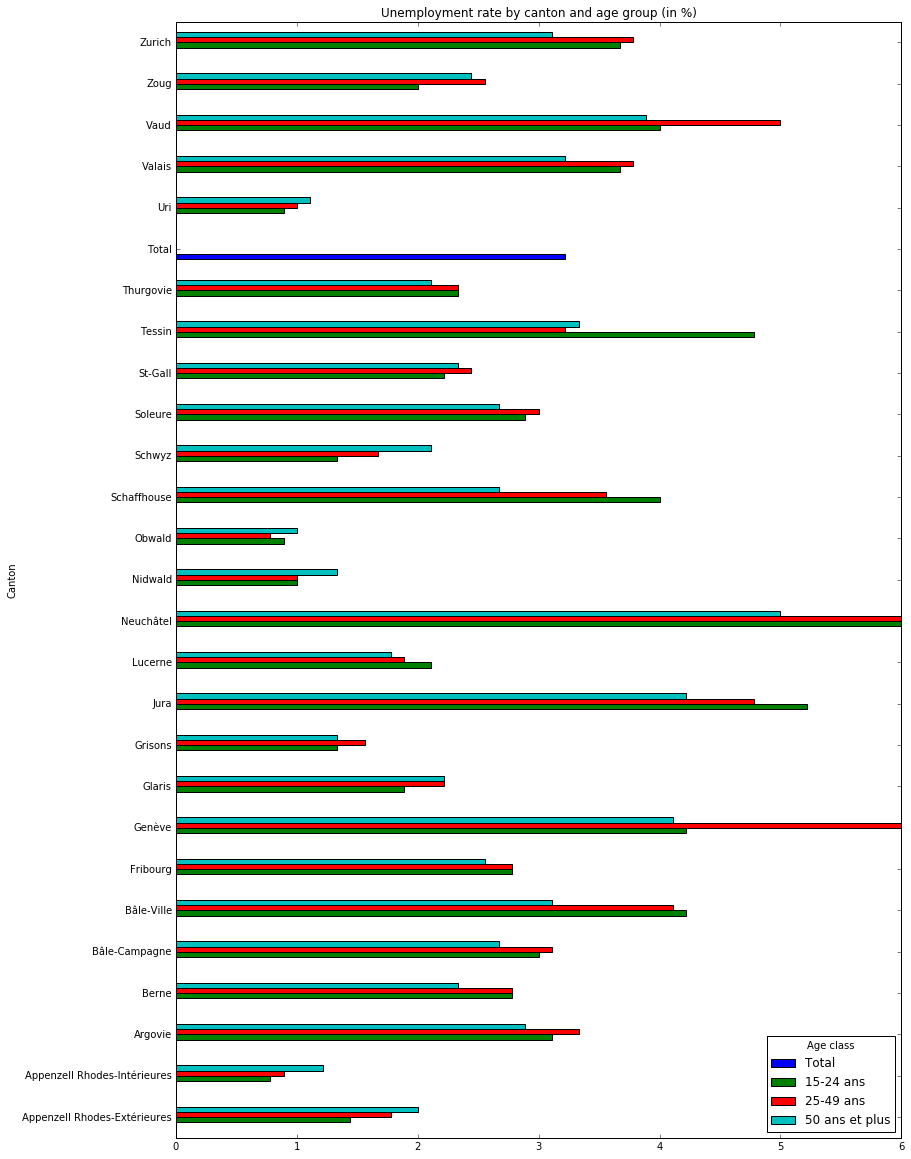

In [39]:
df['Unemployment rate'] = df['Unemployment rate'].astype('float')
df = df.pivot(index='Canton', columns='Age class')
df.columns = df.columns.droplevel()
df.columns.values[0] = 'Total'
plt = df.plot(kind='barh', figsize=(13,20));
plt.set_title('Unemployment rate by canton and age group (in %)');

# Task 4 : difference in unemployment rates between the areas divided by the Röstigraben?

To estimate the difference in unemployment rates between the areas divided by the Röstigraben, we use 2 other Excel datasets. The first contains only unemployment rates in Switzerland per linguistic region for 2017 whereas the second contains in addition the one by canton. Here what they look like (after some usual cleaning as we did before):

In [40]:
# Load the first file 
df1 = pd.read_excel('switz_unemployment_rosti.xlsx')
# Clean the data
df1 = df1.drop(df1.index[0])
df1 = df1[["Région linguistique", "Total"]]
df1.columns.values[-1] = "Unemployment rate"
# recompute the 'Total' column without October
df1['Unemployment rate'] = round(10*df1['Unemployment rate'].astype(np.float)/9, 2)
df1.head()

,Région linguistique,Unemployment rate
1,Suisse alémanique,2.78
2,Suisse romande et Tessin,4.22
3,Total,3.22


In [41]:
# Load the file 
df2 = pd.read_excel('switz_unemployment_rosti_canton.xlsx')
# Clean the data
df2 = df2.drop(df2.index[0])
df2 = df2[["Canton", "Région linguistique", "Total"]]
df2.columns.values[-1] = "Canton unemployment rate"
# recompute the 'Total' column without October
df2['Canton unemployment rate'] = round(10*df2['Canton unemployment rate'].astype(np.float)/9, 2)
df2.head()

,Canton,Région linguistique,Canton unemployment rate
1,Zurich,Suisse alémanique,3.56
2,Berne,Suisse alémanique,2.67
3,Lucerne,Suisse alémanique,1.89
4,Uri,Suisse alémanique,1.00
5,Schwyz,Suisse alémanique,1.78


Now we just have to replace in the second dataframe the values of unemployment rate by those given in the first one depending on the linguistic region of each canton.

In [42]:
# dict which maps linguistic region to its mean unemployment rate
reg2rate = dict(zip(df1["Région linguistique"], df1["Unemployment rate"]))
df2['Region unemployment rate'] = [reg2rate[reg] for reg in df2["Région linguistique"]]
df2 = df2.set_index("Canton")
df2.head()

,Région linguistique,Canton unemployment rate,Region unemployment rate
Canton,,,
Zurich,Suisse alémanique,3.56,2.78
Berne,Suisse alémanique,2.67,2.78
Lucerne,Suisse alémanique,1.89,2.78
Uri,Suisse alémanique,1.00,2.78
Schwyz,Suisse alémanique,1.78,2.78


It only remains to show the map using the functions of the task 3 and the regions unemployment rate

In [43]:
# color scale
colorscale4 = branca.colormap.linear.YlOrRd.scale(0, 5)
colorscale4.caption = "Unemployment rate (%)"

rosti_map = create_map(df2, "Region unemployment rate", colorscale4)
rosti_map